In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets import *
from SR_UNet_simple import *

In [2]:
def FindIndicesOfSpecificPoint(ds, LAT=37, LON=251): #default coords = SW corner of CO
    #lat and lon are ordered to where north and east are positive, respectively
    #adapted from https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb     

    # must pass in an xarray dataset or dataarray with coordinates containing longitude and latitude
        
    abslat = np.abs(ds.latitude.data - LAT)
    abslon = np.abs(ds.longitude.data - LON)
    
    center = np.maximum(abslat, abslon)

    y_c, x_c = np.where(center==np.min(center))
    
    #returns the raw integers of the indices, NOT the xarray or int64
    #ORDER GIVES LON THEN LAT 
    return int(x_c[0]), int(y_c[0])

In [3]:
TIME_LIST = [str(i).zfill(2) for i in range(24)] #["00", "12"]

In [4]:
PATH_HRRR_ORIGINAL = "/scratch/RTMA/alex.schein/Regridded_HRRR"
PATH_TRAIN = "/scratch/RTMA/alex.schein/Regridded_HRRR_train_test/train_spatiallyrestricted_f01"
PATH_TEST = "/scratch/RTMA/alex.schein/Regridded_HRRR_train_test/test_spatiallyrestricted_f01"

In [5]:
urma_sp_rest = xr.open_dataset("/scratch/RTMA/alex.schein/URMA_train_test/train/urma_20210101_t00z.nc", decode_timedelta=True)
urma_orig = xr.open_dataset("/scratch/RTMA/alex.schein/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp", engine="cfgrib", decode_timedelta=True)

skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(2.0)) new_value=Variable(dimensions=(), data=np.float64(10.0))
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/alex.schein/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key pre

In [107]:
IDX_MIN_LON = 595+1 #NOTE: different from URMA grid! 
IDX_MIN_LAT = 645

IMG_SIZE_LON = 180
IMG_SIZE_LAT = 180

RADIUS = 6371950

hrrr_orig = xr.open_dataset(f"/scratch/RTMA/alex.schein/test_hrrr_newgrid_{RADIUS}.grib2", engine='cfgrib', decode_timedelta=True)
hrrr_sp_rest = hrrr_orig.isel(y=slice(IDX_MIN_LAT, IDX_MIN_LAT+IMG_SIZE_LAT),
                        x=slice(IDX_MIN_LON, IDX_MIN_LON+IMG_SIZE_LON))
# t2m_subset.to_netcdf("/scratch/RTMA/alex.schein/test_regridded.nc", encoding={"t2m":{"zlib":True, "complevel":9}})

In [110]:
urma_hrrr_grid = urma_orig.t2m[0:1377, 200:]

In [113]:
print(np.max(np.abs(hrrr_orig.longitude.data-urma_hrrr_grid.longitude.data)))
print(np.min(np.abs(hrrr_orig.longitude.data-urma_hrrr_grid.longitude.data)))

1.067029080559223e-05
2.6716406864579767e-12


In [114]:
print(np.max(np.abs(hrrr_orig.latitude.data-urma_hrrr_grid.latitude.data)))
print(np.min(np.abs(hrrr_orig.latitude.data-urma_hrrr_grid.latitude.data)))

7.543953078936738e-05
4.254763079103441e-05


In [111]:
difference_longitude = np.abs((hrrr_orig.longitude - urma_hrrr_grid.longitude).data)
difference_latitude = np.abs((hrrr_orig.latitude - urma_hrrr_grid.latitude).data)
difference_sqrt = np.sqrt(np.square(difference_latitude)+np.square(difference_longitude))
# np.unravel_index(difference_sqrt.argmin(), difference_sqrt.shape)
np.max(difference_sqrt)

np.float64(7.572535886733259e-05)

Text(0.5, 1.0, 'Misalignment of HRRR and URMA grids, regrid radius = 6371950')

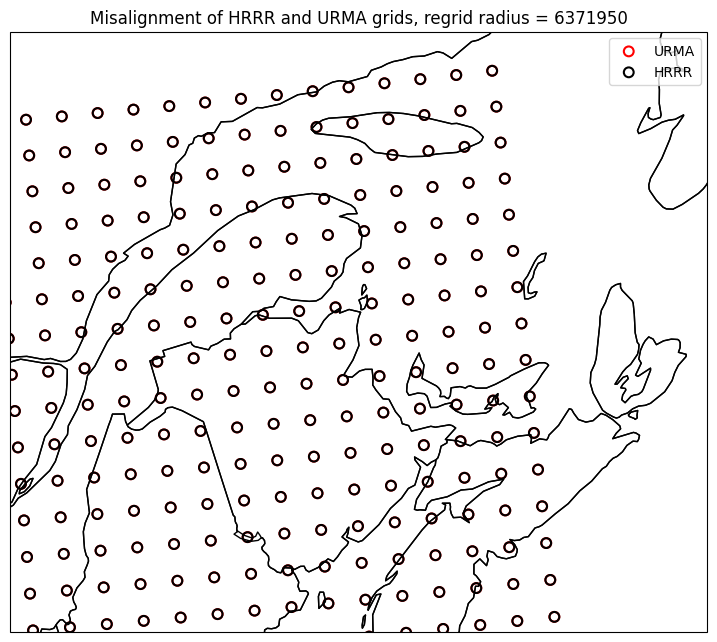

In [115]:
projection = ccrs.LambertConformal(central_longitude = 265-360,
                                    central_latitude = 38.5,
                                    standard_parallels = (38.5,38.5),
                                    cutoff = 0)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(1,1,1, projection=projection)

THINNING = 20

#ax1.set_extent([230-360, 300-360, 19, 50])
# ax1.set_extent([239-360, 239.05-360, 21, 21.05])
ax1.set_extent([300-360, 290-360, 45, 50])
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax1.add_feature(cfeature.STATES.with_scale('50m'))
mks = MarkerStyle('o', fillstyle="none")
ax1.scatter(urma_orig.longitude.data[0:1377:THINNING, 200::THINNING], urma_orig.latitude.data[0:1377:THINNING, 200::THINNING], transform=ccrs.PlateCarree(), s=50, c='r', marker=mks, label='URMA')
ax1.scatter(hrrr_orig.longitude.data[::THINNING, ::THINNING], hrrr_orig.latitude.data[::THINNING, ::THINNING], transform=ccrs.PlateCarree(), s=50, c='k', marker =mks, label='HRRR')

ax1.legend(loc='upper right')
ax1.set_title(f"Misalignment of HRRR and URMA grids, regrid radius = {RADIUS}")

In [28]:
np.shape(hrrr_orig.longitude.data[::THINNING])

(69, 2145)

In [15]:
##############################################

In [16]:
# test_hrrr = xr.open_dataset("/scratch/RTMA/alex.schein/Regridded_HRRR_train_test/train_spatiallyrestricted_f01/hrrr_regridded_spatiallyrestricted_20201231_t23z.nc", decode_timedelta=True)

In [17]:
# projection = ccrs.LambertConformal(central_longitude = 265-360,
#                                     central_latitude = 38.5,
#                                     standard_parallels = (38.5,38.5),
#                                     cutoff = 0)

# fig = plt.figure(figsize=(9,9))
# ax1 = fig.add_subplot(1,1,1, projection=projection)

# #ax1.set_extent([230-360, 300-360, 19, 50])
# ax1.set_extent([251-360, 251.2-360, 39, 39.2])
# ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
# ax1.add_feature(cfeature.STATES.with_scale('50m'))
# mks = MarkerStyle('o', fillstyle="none")
# ax1.scatter(urma_sp_rest.longitude.data, urma_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='r', marker=mks, label='URMA')
# ax1.scatter(test_hrrr.longitude.data, test_hrrr.latitude.data, transform=ccrs.PlateCarree(), s=50, c='k', marker =mks, label='HRRR')


In [18]:
# np.min(test_hrrr.latitude.data - urma_sp_rest.latitude.data)